### Content:

1. [Importing Libraries](#section1)
1. [Reading Data](#section2)
1. [Exploratory Data Analysis](#section3)
1. [Feature Engineering](#section4)
1. [Splitting to Avoid Data Leakage](#section5)
1. [Evaluating Valid Transactions](#section6)
1. [Evaluating Fraud Transactions](#section7)
1. [Training Data Analysis](#section8)
1. [Model Creation](#section9)
1. [One Hot Encoding](#section10)
1. [Frequency Encoding](#section11)
1. [Applying SMOTE ](#section12)
1. [Hyperparameter Tuning for Logistic Regression](#section13)
1. [Hyperparameter Tuning for Random Forest](#section14)
1. [Optimal Threshold Selection](#section15)
1. [Model Evaluation](#section16)
1. [Precision Recall Curve](#section17)
1. [Confusion Matrix ](#section18)
1. [Saving the Model](#section19)
1. [Unexplored Thoughts](#section20)

In [5]:
# !pip install category_encoders
# !pip install imblearn

### Importing Libraries
<a id='section1'></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
import math
import collections 
import pickle

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import RandomizedSearchCV
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score,precision_score,recall_score,average_precision_score

sns.set(style="ticks", color_codes=True)
%matplotlib inline  

### Reading data
<a id='section2'></a>

In [2]:
trx_data=pd.read_csv("data\\transactions.csv",parse_dates = ['CREATED_DATE'])
frauds=pd.read_csv("data\\fraudsters.csv")
users_data=pd.read_csv("data\\users.csv",parse_dates = ['CREATED_DATE','BIRTH_DATE'])

In [3]:
trx_data.head(3)

,ID,USER_ID,CREATED_DATE,TYPE,STATE,AMOUNT_GBP,CURRENCY
0,9499c9c9-c9a9-410f-820d-c6e92fed27fb,00001f33-1d47-47a3-8955-e719172e788b,2019-04-11 20:53:54.700,TOPUP,REVERTED,0.01,EUR
1,b310db00-490f-4185-b247-c59f5694dd67,00001f33-1d47-47a3-8955-e719172e788b,2019-04-11 20:54:02.156,TOPUP,COMPLETED,8.92,EUR
2,e6021128-f4c1-4164-b3de-697e66ad613c,00001f33-1d47-47a3-8955-e719172e788b,2019-04-11 20:55:20.996,FEE,COMPLETED,5.34,EUR


In [4]:
frauds.head(3)

,USER_ID
0,005ab95c-e876-4bf1-a5ea-bc3decfcacfc
1,00645cf3-2589-48ff-b7df-c391eb4ce2c2
2,00e26a77-0f19-421c-b154-f36cbd04638f


In [5]:
users_data.head(3)

,ID,CREATED_DATE,COUNTRY,BIRTH_DATE
0,00001f33-1d47-47a3-8955-e719172e788b,2019-04-11 20:49:42.623,IE,1994-08-17
1,00005048-a584-4b94-a0fc-481c7bc916f1,2019-04-08 08:56:33.595,GB,1967-09-08
2,0000bc95-82c9-4c4b-a422-e807da1e9443,2019-04-04 10:00:52.468,FR,1992-08-11


In [6]:
frauds.describe()

,USER_ID
count,757
unique,757
top,91a42466-3353-4840-9eae-a8e8c019f2e3
freq,1


In [7]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200250 entries, 0 to 200249
Data columns (total 4 columns):
ID              200250 non-null object
CREATED_DATE    200250 non-null datetime64[ns]
COUNTRY         200250 non-null object
BIRTH_DATE      200250 non-null datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 6.1+ MB


In [8]:
trx_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068361 entries, 0 to 1068360
Data columns (total 7 columns):
ID              1068361 non-null object
USER_ID         1068361 non-null object
CREATED_DATE    1068361 non-null datetime64[ns]
TYPE            1068361 non-null object
STATE           1068361 non-null object
AMOUNT_GBP      1068361 non-null float64
CURRENCY        1068361 non-null object
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 57.1+ MB


In [9]:
trx_data.describe()

,AMOUNT_GBP
count,1.068361e+06
mean,3.408766e+01
std,2.350485e+02
min,1.000000e-02
25%,1.000000e-02
50%,8.370000e+00
75%,1.702000e+01
max,8.325073e+04


#### Frauds Data:  757 users are marked as fraud
#### Users Data: 200250 users are in total with no missing values
#### Transactions Data: contains information at transaction level with no missing values
Amount_GBP is the only numeric column

In [10]:
superset=trx_data['USER_ID'].unique()
subset=frauds['USER_ID'].unique()

In [11]:
flag = 0
if(set(subset).issubset(set(superset))): 
    flag = 1
print(flag)

1


user level information corresponding to all transactions is present and so merged with transactions and  fraud label is also added

In [12]:
transactional_data = pd.merge(trx_data, users_data, left_on='USER_ID', right_on='ID')

In [13]:
transactional_data.drop('ID_y',axis=1,inplace=True)
transactional_data.rename(columns={'CREATED_DATE_x': 'TRANSACTION_DATE', 'CREATED_DATE_y': 'SIGNUP_DATE','ID_x':'ID'},inplace=True)

In [14]:
transactional_data['Fraud']=[1 if x in frauds['USER_ID'].unique() else 0 for x in transactional_data['USER_ID']] 

### Exploratory Data Analysis
<a id='section3'></a>

In [15]:
transactional_data.head(2)

,ID,USER_ID,TRANSACTION_DATE,TYPE,STATE,AMOUNT_GBP,CURRENCY,SIGNUP_DATE,COUNTRY,BIRTH_DATE,Fraud
0,9499c9c9-c9a9-410f-820d-c6e92fed27fb,00001f33-1d47-47a3-8955-e719172e788b,2019-04-11 20:53:54.700,TOPUP,REVERTED,0.01,EUR,2019-04-11 20:49:42.623,IE,1994-08-17,0
1,b310db00-490f-4185-b247-c59f5694dd67,00001f33-1d47-47a3-8955-e719172e788b,2019-04-11 20:54:02.156,TOPUP,COMPLETED,8.92,EUR,2019-04-11 20:49:42.623,IE,1994-08-17,0


Each feature is explored visually and facts are stored

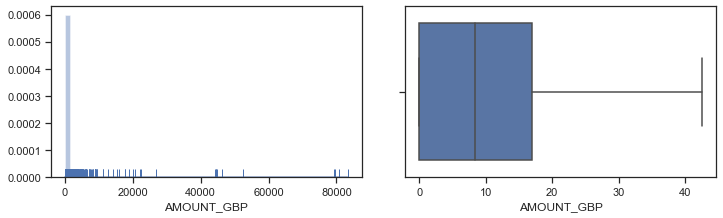

In [16]:
fig, ax =plt.subplots(1,2,figsize=(10,3))
fig.tight_layout()
sns.distplot(transactional_data['AMOUNT_GBP'], rug=True,ax=ax[0])
sns.boxplot(transactional_data["AMOUNT_GBP"],ax=ax[1],showfliers=False)

AMOUNT_GBP is right skewed and affected by outliers

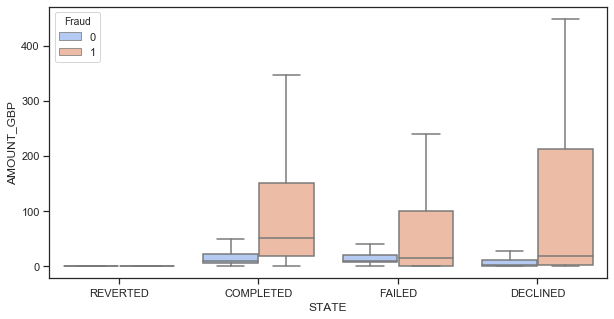

In [17]:
plt.figure(figsize=(10,5))
sns.boxplot(x="STATE",y="AMOUNT_GBP",hue="Fraud",data=transactional_data, palette="coolwarm",showfliers=False)

REVERTED transactions amount are very less for both fraud and non-fraud,so only used to confirm the new account linked.
FAILED and DECLINED transactions have significant variance between the two classes.
COMPLETED transactions are the only one that affects the balance

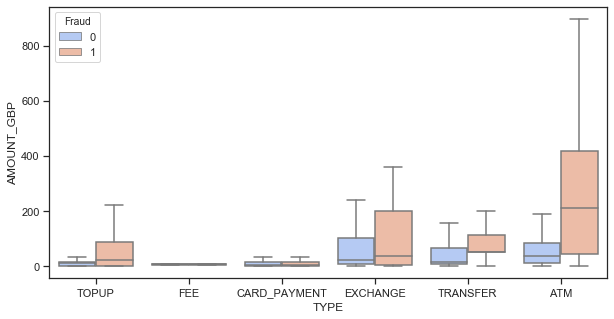

In [18]:
plt.figure(figsize=(10,5))
sns.boxplot(x="TYPE",y="AMOUNT_GBP",hue="Fraud",data=transactional_data, palette="coolwarm",showfliers=False)

FEE and CARD_PAYMENT are not that much significant to distinguish two classes 

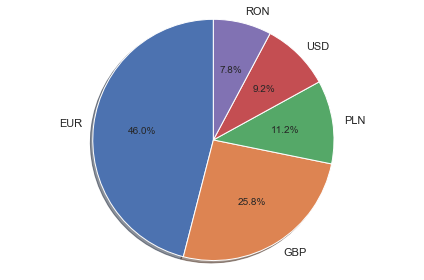

In [19]:
currencies=transactional_data['CURRENCY'].value_counts().head(5)/len(transactional_data)*100
labels1=currencies.index.values.tolist()
countries=transactional_data['COUNTRY'].value_counts().head(5)/len(transactional_data)*100
labels2=countries.index.values.tolist()
fig1, ax1 = plt.subplots()
ax1.pie(currencies, labels=labels1, autopct='%1.1f%%',shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')
plt.tight_layout()
plt.show()

Most of the transactions original currency are EUR and GBP

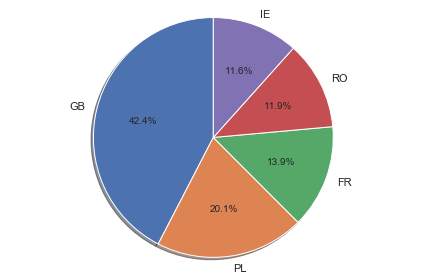

In [20]:
fig1, ax1 = plt.subplots()
ax1.pie(countries, labels=labels2, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')
plt.tight_layout()
plt.show()

Most of the users are from GB and PL

### Feature Engineering
<a id='section4'></a>

In [21]:
transactional_data.shape

(1068361, 11)

#### Based on above facts, transactions are filtered as per their STATE and TYPE

In [22]:
transactional_data=transactional_data[~transactional_data['STATE'].isin(['FAILED','DECLINED']) & ~transactional_data['TYPE'].isin(['FEE','CARD_PAYMENT'])]
transactional_data.shape

(599134, 11)

In [23]:
transactional_data['AGE']=transactional_data['SIGNUP_DATE'] - transactional_data['BIRTH_DATE']
transactional_data['AGE']=transactional_data['AGE']/np.timedelta64(1,'Y')
transactional_data['trx_done_after'] = transactional_data['TRANSACTION_DATE'] - transactional_data['SIGNUP_DATE']
transactional_data['first_trx_done_after_ndays']=transactional_data['trx_done_after']/np.timedelta64(1,'D')


In [24]:
transactional_data=transactional_data.sort_values(['USER_ID','trx_done_after', 'first_trx_done_after_ndays'], ascending=[True, True, True])

In [25]:
transactional_data.corr()

,AMOUNT_GBP,Fraud,AGE,first_trx_done_after_ndays
AMOUNT_GBP,1.000000,0.039799,0.032755,0.141961
Fraud,0.039799,1.000000,-0.058006,0.022494
AGE,0.032755,-0.058006,1.000000,-0.087290
first_trx_done_after_ndays,0.141961,0.022494,-0.087290,1.000000


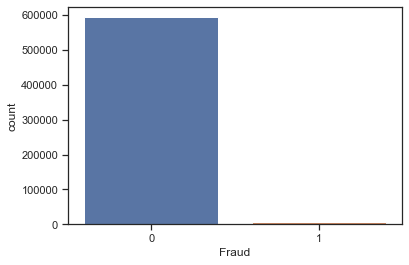

In [26]:
sns.countplot(transactional_data['Fraud'])

### Splitting to avoid Data Leakage
<a id='section5'></a>
In an imbalanced dataset, data leakage is another worst thing that can happen, so a proper splitting strategy is needed

In [27]:
train,test=train_test_split(frauds, test_size=0.25,random_state=0)

In [28]:
print("Total USERS are :" ,transactional_data['USER_ID'].nunique())
print("Total transactions are :" ,transactional_data.shape[0])

Total USERS are : 199483
Total transactions are : 599134


In [29]:
fraud_users=frauds['USER_ID'].tolist()
train_fraud_users=train['USER_ID'].tolist()
test_fraud_users=test['USER_ID'].tolist()

In [30]:
total_fraud_trx=transactional_data[transactional_data['USER_ID'].isin(fraud_users)]
train_fraud_data=transactional_data[transactional_data['USER_ID'].isin(train_fraud_users)]
test_fraud_data=transactional_data[transactional_data['USER_ID'].isin(test_fraud_users)]

In [31]:
print("Total Fraud USERS are :" ,frauds.shape[0])
print("Total Fraud transactions are :" ,total_fraud_trx.shape[0])
print("Fraud transactions for training are :" ,train_fraud_data.shape[0])
print("Fraud transactions for testing are :" ,test_fraud_data.shape[0])

Total Fraud USERS are : 757
Total Fraud transactions are : 5565
Fraud transactions for training are : 4213
Fraud transactions for testing are : 1352


#### Getting valid users and their transactions count


In [32]:
valid_transactions=transactional_data[transactional_data['Fraud']==0]
valid_users=valid_transactions['USER_ID'].unique()

In [33]:
train_valid_users=valid_users[:149045]
test_valid_users=valid_users[149045:]

### Evaluating valid transactions
<a id='section6'></a>

In [34]:
valid_users[:5]

array(['00001f33-1d47-47a3-8955-e719172e788b',
       '00005048-a584-4b94-a0fc-481c7bc916f1',
       '0000bc95-82c9-4c4b-a422-e807da1e9443',
       '0000e262-23b9-4764-82d1-1d4d07ac63b7',
       '0001319d-92c5-4c95-bfea-98c4e65c461b'], dtype=object)

In [35]:
valid_transactions[valid_transactions['USER_ID']=='0001319d-92c5-4c95-bfea-98c4e65c461b']

,ID,USER_ID,TRANSACTION_DATE,TYPE,STATE,AMOUNT_GBP,CURRENCY,SIGNUP_DATE,COUNTRY,BIRTH_DATE,Fraud,AGE,trx_done_after,first_trx_done_after_ndays
25,ab80633d-f0e8-493a-8a5f-1d07528754ef,0001319d-92c5-4c95-bfea-98c4e65c461b,2019-04-19 15:55:49.682,TOPUP,REVERTED,0.01,GBP,2019-04-19 15:18:30.358,GB,2001-04-19,0,18.000747,0 days 00:37:19.324000,0.025918
26,6f3ef2ef-ef68-48ac-b231-5a50a86d99c7,0001319d-92c5-4c95-bfea-98c4e65c461b,2019-04-19 15:56:19.027,TOPUP,COMPLETED,10.00,GBP,2019-04-19 15:18:30.358,GB,2001-04-19,0,18.000747,0 days 00:37:48.669000,0.026258
27,a6c3a1f8-7aba-48b4-9dd4-a6223dd79f00,0001319d-92c5-4c95-bfea-98c4e65c461b,2019-04-20 21:33:38.665,EXCHANGE,COMPLETED,1.00,EUR,2019-04-19 15:18:30.358,GB,2001-04-19,0,18.000747,1 days 06:15:08.307000,1.260513
28,5c520194-97cb-44c9-b420-978b70529a38,0001319d-92c5-4c95-bfea-98c4e65c461b,2019-04-20 21:41:27.564,EXCHANGE,COMPLETED,0.99,GBP,2019-04-19 15:18:30.358,GB,2001-04-19,0,18.000747,1 days 06:22:57.206000,1.265940


### Evaluating fraud patterns
<a id='section7'></a>

In [36]:
fraud_users[:5]

['005ab95c-e876-4bf1-a5ea-bc3decfcacfc',
 '00645cf3-2589-48ff-b7df-c391eb4ce2c2',
 '00e26a77-0f19-421c-b154-f36cbd04638f',
 '013580c7-5744-4d4c-babf-e57ed0105420',
 '0211c232-1cc5-4591-9d1e-e132dd89ce92']

###  (topups and transfers)


In [37]:
total_fraud_trx[total_fraud_trx['USER_ID']=='005ab95c-e876-4bf1-a5ea-bc3decfcacfc']

,ID,USER_ID,TRANSACTION_DATE,TYPE,STATE,AMOUNT_GBP,CURRENCY,SIGNUP_DATE,COUNTRY,BIRTH_DATE,Fraud,AGE,trx_done_after,first_trx_done_after_ndays
1347,5a547cc6-bd0f-46cc-8387-f19f5e76a274,005ab95c-e876-4bf1-a5ea-bc3decfcacfc,2019-04-09 21:08:24.744,TOPUP,REVERTED,0.01,GBP,2019-03-25 11:46:24.460,GB,2001-02-11,1,18.115336,15 days 09:22:00.284000,15.390281
1348,bab469c4-4b5f-47fa-b175-3ba91c350d92,005ab95c-e876-4bf1-a5ea-bc3decfcacfc,2019-04-09 21:08:49.887,TOPUP,COMPLETED,20.00,GBP,2019-03-25 11:46:24.460,GB,2001-02-11,1,18.115336,15 days 09:22:25.427000,15.390572
1352,414a1507-6de0-429b-aad3-39a8363aafec,005ab95c-e876-4bf1-a5ea-bc3decfcacfc,2019-04-09 21:15:13.258,TRANSFER,COMPLETED,20.00,GBP,2019-03-25 11:46:24.460,GB,2001-02-11,1,18.115336,15 days 09:28:48.798000,15.395009
1353,f19e6629-4765-4842-a3e8-1b8ad2533809,005ab95c-e876-4bf1-a5ea-bc3decfcacfc,2019-04-12 01:19:59.791,TOPUP,REVERTED,0.01,GBP,2019-03-25 11:46:24.460,GB,2001-02-11,1,18.115336,17 days 13:33:35.331000,17.564992
1355,bbce6fb8-81df-4002-b4ae-1eed4e246b13,005ab95c-e876-4bf1-a5ea-bc3decfcacfc,2019-04-12 21:20:58.166,TOPUP,REVERTED,0.01,GBP,2019-03-25 11:46:24.460,GB,2001-02-11,1,18.115336,18 days 09:34:33.706000,18.399001
1356,39281edd-f399-4ddd-bedb-5b680d78134d,005ab95c-e876-4bf1-a5ea-bc3decfcacfc,2019-04-12 21:21:09.993,TOPUP,COMPLETED,40.00,GBP,2019-03-25 11:46:24.460,GB,2001-02-11,1,18.115336,18 days 09:34:45.533000,18.399138
1357,3c38fe77-34d1-4743-bfb5-0a4b16feaf40,005ab95c-e876-4bf1-a5ea-bc3decfcacfc,2019-04-12 21:43:39.916,TOPUP,COMPLETED,40.00,GBP,2019-03-25 11:46:24.460,GB,2001-02-11,1,18.115336,18 days 09:57:15.456000,18.414762
1360,1f67e52d-5ae4-47ea-8694-6bb641a0185e,005ab95c-e876-4bf1-a5ea-bc3decfcacfc,2019-04-12 22:00:19.243,TRANSFER,COMPLETED,80.00,GBP,2019-03-25 11:46:24.460,GB,2001-02-11,1,18.115336,18 days 10:13:54.783000,18.426329
1361,4d3336fe-d1df-4d5e-ac9c-9fe94d3cb816,005ab95c-e876-4bf1-a5ea-bc3decfcacfc,2019-04-13 10:15:47.969,TOPUP,REVERTED,0.01,USD,2019-03-25 11:46:24.460,GB,2001-02-11,1,18.115336,18 days 22:29:23.509000,18.937078
1365,2d794578-7564-4831-962c-c801bc76828a,005ab95c-e876-4bf1-a5ea-bc3decfcacfc,2019-04-13 13:21:03.833,TOPUP,REVERTED,0.01,USD,2019-03-25 11:46:24.460,GB,2001-02-11,1,18.115336,19 days 01:34:39.373000,19.065733


In [38]:
print("Total Valid USERS are :" ,len(valid_users))
print("Total Valid transactions are :" ,valid_transactions.shape[0])
print("Valid transactions for training are :" ,len(train_valid_users))
print("Valid transactions for testing are :" ,len(test_valid_users))

Total Valid USERS are : 198730
Total Valid transactions are : 593569
Valid transactions for training are : 149045
Valid transactions for testing are : 49685


In [39]:
train_valid_data=transactional_data[transactional_data['USER_ID'].isin(train_valid_users)]
test_valid_data=transactional_data[transactional_data['USER_ID'].isin(test_valid_users)]

In [40]:
train_data=pd.concat([train_valid_data,train_fraud_data]).reset_index(drop=True)
test_data=pd.concat([test_valid_data,test_fraud_data]).reset_index(drop=True)
print("Training data shape",train_data.shape)
print("Testing data shape",test_data.shape)

Training data shape (449355, 14)
Testing data shape (149779, 14)


confirms no data leakage by evaluating at user level

In [41]:
set(train_data['USER_ID'].unique()) & set(test_data['USER_ID'].unique())

set()

### Training Data analysis
<a id='section8'></a>

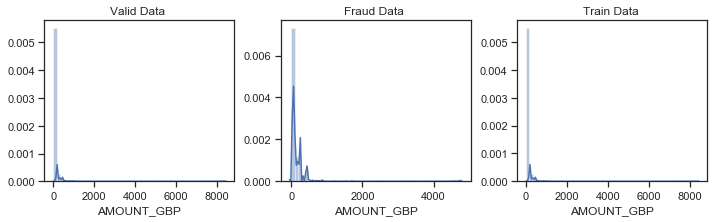

In [42]:
fig, ax =plt.subplots(1,3,figsize=(10, 3))
ax[0].title.set_text('Valid Data ')
ax[1].title.set_text('Fraud Data ')
ax[2].title.set_text('Train Data ')
fig.tight_layout()
sns.distplot(train_valid_data["AMOUNT_GBP"], ax=ax[0])
sns.distplot(train_fraud_data["AMOUNT_GBP"], ax=ax[1])
sns.distplot(train_data["AMOUNT_GBP"], ax=ax[2])

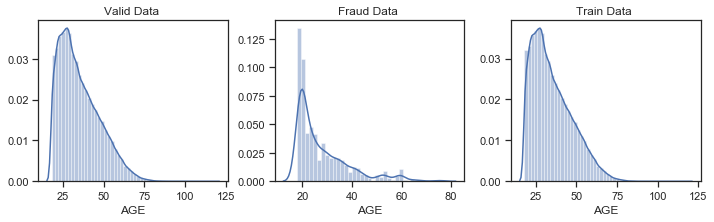

In [43]:
fig, ax =plt.subplots(1,3, figsize=(10, 3))

ax[0].title.set_text('Valid Data ')
ax[1].title.set_text('Fraud Data ')
ax[2].title.set_text('Train Data ')
fig.tight_layout()
sns.distplot(train_valid_data["AGE"], ax=ax[0])
sns.distplot(train_fraud_data["AGE"], ax=ax[1])
sns.distplot(train_data["AGE"], ax=ax[2])

#### AGE varies for fraud and non-fraud (valid) transactions

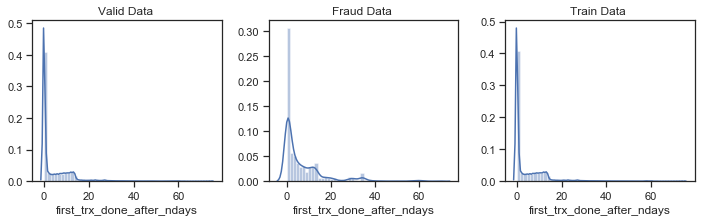

In [44]:
fig, ax =plt.subplots(1,3,figsize=(10, 3))
ax[0].title.set_text('Valid Data ')
ax[1].title.set_text('Fraud Data ')
ax[2].title.set_text('Train Data ')
fig.tight_layout()
sns.distplot(train_valid_data["first_trx_done_after_ndays"], ax=ax[0])
sns.distplot(train_fraud_data["first_trx_done_after_ndays"], ax=ax[1])
sns.distplot(train_data["first_trx_done_after_ndays"], ax=ax[2])

There are currencies which are in test but not in train and also don't have frauds

In [45]:
set(test_data['CURRENCY'].unique()) - set(train_data['CURRENCY'].unique())

{'BBD', 'BSD', 'MNT', 'SCR', 'UZS'}

In [46]:
transactional_data[transactional_data['CURRENCY'].isin(['BZD', 'GTQ', 'UZS'])].Fraud.sum()

0

### Model Creation
<a id='section9'></a>

In [47]:
training_data=train_data[['ID','USER_ID','TYPE','STATE','AMOUNT_GBP','CURRENCY','COUNTRY','AGE','first_trx_done_after_ndays','Fraud']].set_index('ID')
testing_data=test_data[['ID','USER_ID','TYPE','STATE','AMOUNT_GBP','CURRENCY','COUNTRY','AGE','first_trx_done_after_ndays','Fraud']].set_index('ID')


In [48]:
X_train=training_data.drop(['USER_ID','Fraud'],axis=1)
y_train=training_data['Fraud']
X_test=testing_data.drop(['USER_ID','Fraud'],axis=1)
y_test=testing_data['Fraud']

### One Hot Encoding
<a id='section10'></a>

In [49]:
ce_one_hot = ce.OneHotEncoder(cols = ['TYPE','STATE'])
ce_one_hot=ce_one_hot.fit(X_train)
X_train=ce_one_hot.transform(X_train)

In [50]:
X_test=ce_one_hot.transform(X_test)

### Frequency Encoding
<a id='section11'></a>

In [51]:
X_train['CURRENCY_LEVEL'] = round(X_train.groupby('CURRENCY')['CURRENCY'].transform('count')/X_train.shape[0],2)
X_train['COUNTRY_LEVEL'] = round(X_train.groupby('COUNTRY')['COUNTRY'].transform('count')/X_train.shape[0],2)
currency_encoding=pd.Series(X_train['CURRENCY_LEVEL'].values,index=X_train['CURRENCY']).to_dict()
country_encoding=pd.Series(X_train['COUNTRY_LEVEL'].values,index=X_train['COUNTRY']).to_dict()
X_train.drop(['CURRENCY','COUNTRY'],axis=1,inplace=True)

In [52]:
X_test['CURRENCY_LEVEL'] = X_test['CURRENCY'].map(currency_encoding) 
X_test['COUNTRY_LEVEL'] = X_test['COUNTRY'].map(country_encoding) 
X_test.fillna(0,inplace=True)
X_test[X_test['CURRENCY']== 'BZD']
X_test.drop(['CURRENCY','COUNTRY'],axis=1,inplace=True)

In [53]:
scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train  = pd.DataFrame(data = scaler.transform(X_train), columns = X_train.columns,index = X_train.index)
X_test  = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns,index = X_test.index)

### Applying SMOTE
<a id='section12'></a>

In [54]:
regularization_strength=[0.01,0.1,1,10]
max_depth=[7,9,11,13]
n_estimators=[7,9,11,13]
weights=np.linspace(0.05,0.25,10)
class_weights=[{0: 1, 1: 4},{0: 1, 1:2},{0: 1, 1: 3}]
sm = SMOTE(random_state=0,sampling_strategy='minority')
lr = LogisticRegression(random_state=0, solver='lbfgs')
rf = RandomForestClassifier(random_state=0)

In [55]:
lr_pipeline = Pipeline([('SMOTE', sm),('Logistic Regression', lr)])
rf_pipeline = Pipeline([('SMOTE', sm),('Random Forest', rf)])

### Hyperparameter Tuning for Logistic Regression
<a id='section13'></a>

In [56]:
lr_gsc=GridSearchCV(
    estimator=lr_pipeline,
    param_grid={
        'SMOTE__ratio':weights,
        'Logistic Regression__class_weight':class_weights,
        'Logistic Regression__C' : regularization_strength
    },
scoring='f1',
cv=3
)

### Hyperparameter Tuning for Random Forest
<a id='section14'></a>

In [57]:
rf_gsc=GridSearchCV(
    estimator=rf_pipeline,
    param_grid={
        'SMOTE__ratio':weights,
        'Random Forest__class_weight':class_weights,
        'Random Forest__max_depth' : max_depth,
        'Random Forest__n_estimators': n_estimators
    },
scoring='f1',
cv=3
)

In [58]:
lr_result=lr_gsc.fit(X_train,y_train)

In [59]:
print(lr_result.best_params_)
print(lr_result.best_score_)

{'Logistic Regression__C': 0.01, 'Logistic Regression__class_weight': {0: 1, 1: 2}, 'SMOTE__ratio': 0.07222222222222223}
0.1301581389183705


In [60]:
rf_result=rf_gsc.fit(X_train,y_train)

In [61]:
print(rf_result.best_params_)
print(rf_result.best_score_)

{'Random Forest__class_weight': {0: 1, 1: 2}, 'Random Forest__max_depth': 13, 'Random Forest__n_estimators': 13, 'SMOTE__ratio': 0.05}
0.40305785874556466


### Prediction

In [62]:
y_pred_lr=lr_result.predict_proba(X_test)[:, 1]
y_pred_rf=rf_result.predict_proba(X_test)[:, 1]

### Optimal Threshold Selection
<a id='section15'></a>

In [63]:
def cutoff(precision,recall,threshold):
    threshold_deciderf1=[]
    for value in zip(precision,recall):
        p=value[0]
        r=value[1]
        f1=(2*p*r)/(p+r)
        threshold_deciderf1.append(f1)
    opt_threshold_index=threshold_deciderf1.index(max(threshold_deciderf1)) 
    opt_thresholdf1=threshold[opt_threshold_index]
    return opt_thresholdf1

In [64]:
lr_precision, lr_recall, lr_threshold = precision_recall_curve(y_test,y_pred_lr,pos_label=1)
lr_opt_threshold = cutoff(lr_precision,lr_recall,lr_threshold)
print('Optimal threshold set for Logistic Regression ',lr_opt_threshold)
y_pred_lr1 = y_pred_lr > lr_opt_threshold

Optimal threshold set for Logistic Regression  0.5754152036784177


C:\Users\hjuneja\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [65]:
rf_precision, rf_recall, rf_threshold = precision_recall_curve(y_test,y_pred_rf,pos_label=1)
rf_opt_threshold = cutoff(rf_precision, rf_recall, rf_threshold)
print('Optimal threshold set for Random Forest ',rf_opt_threshold)
y_pred_rf1 = y_pred_rf > rf_opt_threshold

Optimal threshold set for Random Forest  0.5695059271595772


### Model Performance Evaluation
<a id='section16'></a>

In [66]:
print("Logistic Regression Metrics : ")
print("Precision:",precision_score(y_test, y_pred_lr1,pos_label = 1))
print("Recall:",recall_score(y_test, y_pred_lr1,pos_label = 1))
print("F1:",f1_score(y_test, y_pred_lr1,pos_label = 1))

Logistic Regression Metrics : 
Precision: 0.11058946270213876
Recall: 0.15680473372781065
F1: 0.1297032731722239


In [67]:
print("Random Forest Metrics : ")
print("Precision:",precision_score(y_test, y_pred_rf1,pos_label = 1))
print("Recall:",recall_score(y_test, y_pred_rf1,pos_label = 1))
print("F1:",f1_score(y_test, y_pred_rf1,pos_label = 1))

Random Forest Metrics : 
Precision: 0.4334763948497854
Recall: 0.3735207100591716
F1: 0.4012713547874453


### Precision-Recall Curve
<a id='section17'></a>

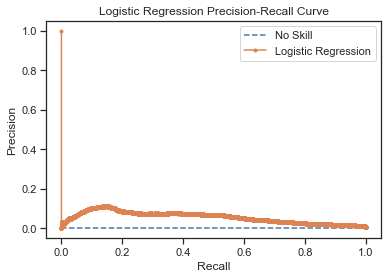

In [68]:
# plot the precision-recall curves
no_skill = len([y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic Regression')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Logistic Regression Precision-Recall Curve")
# show the legend
plt.legend()
# show the plot
plt.show()
## added class_weights to get this

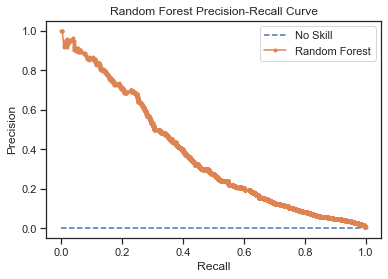

In [69]:
# plot the precision-recall curves
no_skill = len([y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(rf_recall, rf_precision, marker='.', label='Random Forest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Random Forest Precision-Recall Curve")
# show the legend
plt.legend()
# show the plot
plt.show()
## added class_weights to get this

### Confusion Matrix for Models
<a id='section18'></a>

In [70]:
lr_cm=confusion_matrix(y_test, y_pred_lr1)
rf_cm=confusion_matrix(y_test, y_pred_rf1)

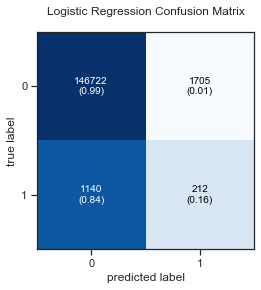

In [71]:
fig, ax = plot_confusion_matrix(conf_mat=lr_cm,show_absolute=True,show_normed=True)
ax.set_title('Logistic Regression Confusion Matrix')
plt.show()

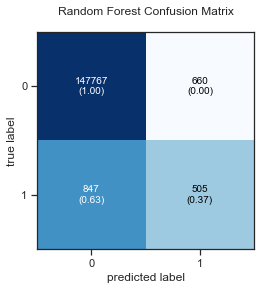

In [72]:
fig,ax=plot_confusion_matrix(conf_mat=rf_cm,show_absolute=True,show_normed=True)
ax.set_title('Random Forest Confusion Matrix')
plt.show()

### Saving the model
<a id='section19'></a>

In [73]:
model_parameters = {}
model_parameters['Scaling'] = scaler
model_parameters['Onehot Encoding'] = ce_one_hot
model_parameters['Currency Encoding'] = currency_encoding
model_parameters['Country Encoding'] = country_encoding
model_parameters['clf'] = rf_gsc
model_parameters['opt_threshold'] = rf_opt_threshold

In [74]:
with open("artifacts/model_parameters.pickle","wb") as file:
    pickle.dump(model_parameters, file)

### Unexplored Thoughts
<a id='section20'></a>

#### For Features
1. How rarely or frequently i.e. the time gap between two transactions (Can be computed from feature trx_done_after_ndays)
2. Sum of TOPUP's Amount is equal to Sum of Transfers Amount for Fraud cases
3. If previous TOPUP Failed, does the amount of next TOPUP same?
4. If previous TOPUP Failed, does a new account linked for next transaction?
5. User does his transactions in how many different currencies?

#### For Optimal Threshold
In cases like fraud detection, where marking a Fraud person as non-fraud is critical (FN). Recall should be more for such cases than Precision. 
So based on this, we can select a optimal threshold that makes the balance between how many alerts can be processed manually corresponding to a high Recall.
Secondly, techniques like Cost Curves can also be used